# Classification : Bayésien naïf, LDA, QDA, et $k$-Plus Proches Voisins

L'objectif de cette séance de TD/TP est
1. d'implémenter les différents algorithmes de classificaion vus en cours 
 * bayésien naïf
 * LDA et QDA 
 * $k$-PPV
2. d'évaluer les performances de classification sur *les échantillons d'apprentissage*
 * calcul d'une matrice de confusion
 * calcul de l'Overall Accuracy et du coefficient Kappa
3. de visualiser les frontières de décision obtenues par les algorithmes de classification

L'ensemble des algorithmes à implémenter sont déterministiques (c'est-à-dire qu'ils ne dépendent pas d'un caractère aléatoire). Vos implémentations devraient donc théoriquement vous donner des résultats strictement identiques à ceux de Scikit-Learn. Cependant, la résolution de LDA par Scikit-Learn n'est pas exacte et l'algorithme des k-PPV peut utiliser de l'aléatoire pour départager les cas d'égalité lors de l'affectation de la classe majoritaire (diapo 32 du cours).

**Indication** : le découpage en fonction (avec les résultats attendus) est là pour vous aider à modulariser votre code. Cependant, vous pouvez partir sur un tout autre choix d'implémentation (notamment d'autres paradigmes de programmation comme l'orienté objet ou le fonctionnel).


## Jeu de données

In [3]:
#-- import
from sklearn import datasets
import math
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics.pairwise import euclidean_distances #to compute pairwise distances
from numpy.linalg import inv #to compute X^-1

In [4]:
#-- Charger le jeu de données iris
iris = datasets.load_iris()
X = iris.data[:,0:2] # on garde uniquement deux variables explicatives
X = (X-X.mean(axis=0))/X.std(axis=0,ddof=0)
y = iris.target

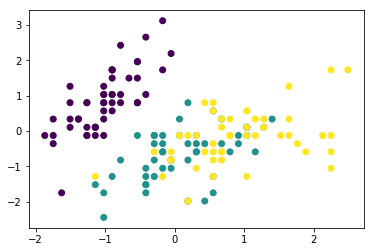

In [5]:
#-- Scatterplot
plt.figure()
plt.scatter(X[:,0],X[:,1], c=y) #plot the points with their label
plt.show()

## Classifieur bayésien naïf

### 1.  Algotihme de Scikit-learn


In [6]:
#-- Trouver le nombre de classes
C = len(np.unique(y))
print("C =", C)

C = 3


In [7]:
#-- Bayésien naif gaussien
gnb = GaussianNB()
y_pred = gnb.fit(X, y).predict(X)
print ("Taux d'erreur du classifieur bayésien naïf", np.mean(y_pred != y))

Taux d'erreur du classifieur bayésien naïf 0.22


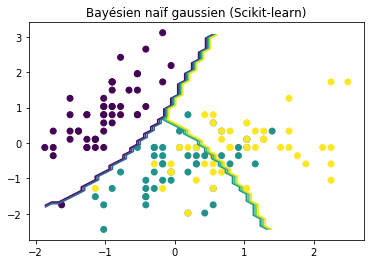

In [8]:
#-- Figure (frontières de décision)
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = gnb.fit(X, y).predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("Bayésien naïf gaussien (Scikit-learn)")
plt.show()


### 2. Votre version de l'algorithme Bayésien naif

Astuces : 
* `np.bincount(y)` permet de compter le nombre d'occurences dans une classe
* `np.mean` et `np.var` permettent de calculer la moyenne et la variance pour une variable explicative
* loi normale pour $z$ la variable aléatoire : $p(z) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{1}{2\sigma^2}(z-\mu)^2}$
* `grid = np.c_[xx.ravel(),yy.ravel()]` défini une matrice avec toutes les positions sur une grille (cf. le code de la Figure ci-dessus)

In [9]:
#-- probabilité a priori (Pr(Y=y))
def proba_classe(y):
    return np.bincount(y) / y.shape[0]

In [10]:
print(proba_classe(y)) #- fréquence d'apparition de chacune des classes dans les données d'apprentissage

[0.33333333 0.33333333 0.33333333]


In [108]:
def estimation_param_nb(X,y):
    nbClasses = proba_classe(y).shape[0]
    mu = []
    sigma2 = []
    for i in range(nbClasses):
        classe =[]
        for j in range(y.shape[0]):
            if y[j] == i:
                classe.append(X[j])
        mu.append(np.mean(classe,axis=0))
        sigma2.append(np.var(classe,axis=0))   
    return (mu,sigma2)

In [109]:
print(estimation_param_nb(X,y))

([array([-1.01457897,  0.84230679]), array([ 0.11228223, -0.65718442]), array([ 0.90229674, -0.18512237])], [array([0.17876968, 0.76185002]), array([0.38334383, 0.51673176]), array([0.5817693 , 0.54577583])])


In [13]:
#-- loi normale (1D)
def loi_normale(x,mu,sigma2):
    return 1/np.sqrt(2*np.pi)*np.sqrt(sigma2)*np.exp(-1/2*sigma2*(x-mu)**2)

In [14]:
loi_normale(X[:,0],mu=0,sigma2=1)[:10]

array([0.26592211, 0.20759165, 0.15281312, 0.12825426, 0.23668473,
       0.34534257, 0.12825426, 0.23668473, 0.08645012, 0.20759165])

In [ ]:
#-- vraisemblance (Pr(X=x|Y=y)) en fonction des paramètres mu et sigma
def vraisemblance_nb(X,mu,sigma2):    
    N, d = X.shape 
    C = mu.shape[0]
    pvrais = np.zeros((N,C))
    for c in range(C):
        #-- à compléter
         for dim in range(d):
             #-- à compléter
    return pvrais

In [ ]:
mu, sigma2 = estimation_param_nb(X,y)
print(vraisemblance_nb(X,mu,sigma2)[:10,:])

In [ ]:
#-- classifieur bayésien naif (NB : Naif Bayesian classifier)
def predict_nb(X,Xtrain,ytrain):
    """
        Prédiction des étiquettes pour les échantillons X lorsque le modèle est appris sur les données (Xtrain,ytrain)
        IN:
            - X (N,d) : observations pour laquelle on souhaite prédire la classe yhat
            - Xtrain (m,d) : données d'apprentissage
            - ytrain (m,): étiqueetes associées aux données d'apprentissage
        OUT:
            - yhat (N,) : classes prédites pour les observations X 
    """
    mu, sigma2 = estimation_param_nb(Xtrain,ytrain)
    yhat = np.argmax(proba_classe(ytrain) * vraisemblance_nb(X, mu, sigma2), axis=1)
    return yhat

In [ ]:
print(predict_nb(X,X,y)) # prédictions sur les données d'apprentissage (donc X=Xtrain dans ce TP)

### 3. Evaluation des performances

In [ ]:
#-- Calcul de la matrice de confusion
def getConfusionMatrix():
    
    
    

In [ ]:
#-- Calcul du taux de bonne classification (OA)
def getOA():
    
    
    

In [ ]:
#-- Calcul du coefficient Kappa
def getKappa():
    
    
    

In [ ]:
#-- test
yhat = predict_nb(X,X,y)
print ("Taux d'erreur du classifieur bayésien naïf", 1-getOA(y,yhat))
print ("\tet coefficient Kappa", getKappa(y,yhat))

In [ ]:
print ("Taux d'erreur du classifieur bayésien naïf (Scikit-learn)", 1-accuracy_score(y,yhat))
print ("\tet coefficient Kappa (Scikit-learn)", cohen_kappa_score(y,yhat))

### 4. Visualisation des frontières de décision

In [ ]:
#-- Figure (frontières de décision) 
## A COMPARER AVEC LE PLOT INITIAL
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = predict_nb(np.c_[xx.ravel(), yy.ravel()],X,y)
Z = Z.reshape(xx.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("Bayésien naïf gaussien (Scikit-learn)")
plt.show()

## LDA et QDA

### 1. Scikit-learn

In [ ]:
#-- LDA 
lda = LinearDiscriminantAnalysis()
lda.fit(X, y) 
y_pred = lda.predict(X)
print ("Taux d'erreur LDA", np.mean(y_pred != y))

In [ ]:
# Figure (frontière de décision)
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),np.arange(y_min, y_max, 0.05))
Z = lda.fit(X, y).predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.show()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("Linear Discriminant Analysis")
plt.show()

In [ ]:
#-- QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y) 
y_pred = qda.predict(X)
print ("Taux d'erreur QDA", np.mean(y_pred != y))

In [ ]:
# Figure (frontière de décision)
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = qda.fit(X, y).predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.show()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("Quadratic Discriminant Analysis")
plt.show()

### 2. Votre version des algorithmes LDA et QDA

Astuce :
* ``np.cov`` calcul de covariance d'une numpy array (`bias=True`pour obtenir des résultats identiques à l'algorithme QDA de Scikit-Learn)
* loi normale multivariée : $p(z) = \frac{1}{(2\pi)^{\frac{d}{2}} |\Sigma|^{\frac{1}{2}}}e^{-\frac{1}{2}(z-\mu)^T \Sigma^{-1}(z-\mu)}$
* ``np.linalg.det`` et ``np.linalg.inv`` calcul de déterminant et de l'inverse d'une numpy array
* ``np.einsum`` (non obligatoire)


In [ ]:
def covariance():
    
    
    

In [ ]:
#-- Test
cov = covariance(X)
print(cov)
print(cov.shape)

In [ ]:
#-- loi normale multivariée
def loi_normale_multivarie(X,mu,Sigma):
    
    
    

In [ ]:
print(loi_normale_multivarie(X,[0, 0],[[1, 0], [0,1]])[:10])

#### LDA

In [ ]:
def estimation_param_lda(Xtrain, ytrain):
    
    
    

In [ ]:
print(estimation_param_lda(X,y))

In [ ]:
#-- vraisemblance (Pr(X=x|Y=y)) en fonction des paramètres mu et sigma
def vraisemblance_lda(X, mu, Sigma):    
    
    
    

In [ ]:
#-- LDA
def predict_lda(X, Xtrain, ytrain):
   



In [ ]:
#-- test
yhat = predict_lda(X,X,y)
print ("Taux d'erreur LDA", 1-getOA(y,yhat))
print ("\tet coefficient Kappa", getKappa(y,yhat))

#### QDA

In [ ]:
def estimation_param_qda(Xtrain, ytrain):
    
    
    
    

In [ ]:
#-- vraisemblance (Pr(X=x|Y=y)) en fonction des paramètres mu et sigma
def vraisemblance_qda(X, mu, Sigma):    
    
    
    

In [ ]:
#-- QDA
def predict_qda(X, Xtrain, ytrain):
    
    
    
    

In [ ]:
#-- test
yhat = predict_qda(X,X,y)
print ("Taux d'erreur QDA", 1-getOA(y,yhat))
print ("\tet coefficient Kappa", getKappa(y,yhat))

**Note** : On remarque que OA(LDA) > OA(QDA), mais Kappa(LDA)<Kappa(QDA).

### 3. Visualisation des frontières de décision

In [ ]:
# Figure (frontière de décision)
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),np.arange(y_min, y_max, 0.05))
Z = predict_lda(np.c_[xx.ravel(), yy.ravel()],X,y)
Z = Z.reshape(xx.shape)

plt.show()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("Linear Discriminant Analysis")
plt.show()

# Figure (frontière de décision)
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = predict_qda(np.c_[xx.ravel(), yy.ravel()],X,y)
Z = Z.reshape(xx.shape)

plt.show()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("Quadratic Discriminant Analysis")
plt.show()

**Note** : Il est possible que le résultat visuel pour votre implémentation de LDA diffère de celle de Scikit-Learn vu précédemment. Cette différence est due à l'utilisation d'un algorithme d'optimisation pour l'apprentissage des paramètres du modèle.

## $k$-Plus Proches Voisins

### 1. Scikit-learn

In [ ]:
#-- k-PPV
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y) 
y_pred = knn.predict(X)
print ("Taux d'erreur du 3-PPV", np.mean(y_pred != y))

In [ ]:
# Figure
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = knn.fit(X, y).predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.show()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("3-NN (scikit learn)")
plt.show()

### 2. Votre version de l'algorithme des $k$-Plus Proches Voisins

Astuces :
* `euclidean_distances()` calculer les distances entre échantillons ([doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html))
* `np.argsort()` donner les indices des points
* `np.unique()` pour avoir les éléments uniques d'une liste (et leur compte `return_counts=True`)
* `map(lambda i:y[i], tri.ravel())` donner les valeurs de y associées au i-ième indice, stocké dans la liste appelée tri

In [ ]:
#-- Votre algorithme
def kPPV(X, Xtrain, ytrain, k=5):
    
    
    

In [ ]:
kPPV(np.array([[0.5, 1.3],[-3.5,0.4],[1.5,-0.4]]),X,y, k=5)

In [ ]:
#-- test
for k in [1,3,5,10,15,30]:
    yhat = kPPV(X,X,y,k=k)
    print ("Taux d'erreur "+str(k)+"-PPV", 1-getOA(y,yhat))
    print ("\tet coefficient Kappa", getKappa(y,yhat))

**Note \#1** : Le taux d'erreur du 1-PPV devrait être de 0 % sur les échantillons d'apprentissage (chaque donnée d'apprentissage est la plus proche d'elle-même). **Comment pouvez vous expliquer le taux d'erreur de 6 % observé ?**

**Note \#2** : Il est rare d'utiliser une implémentation naïve du $k$-PPV qui calcule une distance entre chaque paire d'échantillons (coûteuse en mémoire et en temps). Pour aller plus loin : K-d tree.

**Note \#3** : En plus de l'hyperparamètre $k$ à fixer, le choix de la distance est aussi un hyperparamètre. Dans cet exemple, nous utilisons la distance euclidienne, mais vous pouvez tester d'autres types de distance (par exemple Minkowski pour $p\neq 2$)

### 3. Visualisation des frontières de décision

In [ ]:
# Figure
x_min, x_max, y_min, y_max = np.min(X[:, 0]),np.max(X[:, 0]) ,  np.min(X[:, 1]),  np.max(X[:, 1])
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
Z = kPPV(np.c_[xx.ravel(), yy.ravel()],X,y,k=5)
Z = Z.reshape(xx.shape)

plt.show()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contour(xx, yy, Z)
plt.title("5-PPV (scikit learn)")
plt.show()